In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib
import matplotlib.pyplot as plt
import math
from datetime import datetime as dt
import random
import matplotlib.ticker as mtick

In [369]:
eq_df = pd.read_csv('Data.csv')
eq_df.set_index('Dates', inplace=True)
df = eq_df['Dow Jones']
df = pd.DataFrame(df)
df.index = pd.to_datetime(df.index, format = '%d/%m/%Y')#.strftime('%d-%m-%Y')
df = df.loc[df.groupby(df.index.to_period('M')).apply(lambda x: x.index.max())]
df['DJIA_Return'] = df['Dow Jones'].pct_change()
df.dropna(inplace=True)

df['Entry'] = ""
df['12mth_TSMOM'] = 0

# TSMOM
# Buy when the 12mth return is positive
for i in range(12, df.shape[0]):
    if ((df.iloc[i-1,0] - df.iloc[i-12,0])/df.iloc[i-12,0]) > 0:
        df.iloc[i,2] = "Invested"
        df.iloc[i,-1] = df.iloc[i,1]

# Add Transaction costs
for i in range(df.shape[0]):
        if df.iloc[i,2] != df.iloc[i-1,2]:
            df.iloc[i,-1] -= 0.0005

df

,Dow Jones,DJIA_Return,Entry,12mth_TSMOM
Dates,,,,
1900-02-28,63.96,-0.032814,,-0.000500
1900-03-31,65.39,0.022358,,0.000000
1900-04-30,61.33,-0.062089,,0.000000
1900-05-31,59.10,-0.036361,,0.000000
1900-06-30,54.83,-0.072250,,0.000000
...,...,...,...,...
2022-10-31,32732.95,0.139508,,0.000000
2022-11-30,34589.77,0.056726,,0.000000
2022-12-30,33147.25,-0.041704,,0.000000


In [370]:
# Growth of $100
strategy = round((1+df['12mth_TSMOM']).cumprod() * 100, 0)
bmk = round((1+df['DJIA_Return']).cumprod() * 100, 0)
print(strategy, bmk)

Dates
1900-02-28      100.0
1900-03-31      100.0
1900-04-30      100.0
1900-05-31      100.0
1900-06-30      100.0
               ...   
2022-10-31    36853.0
2022-11-30    36853.0
2022-12-30    36853.0
2023-01-31    36853.0
2023-02-08    36813.0
Name: 12mth_TSMOM, Length: 1477, dtype: float64 Dates
1900-02-28       97.0
1900-03-31       99.0
1900-04-30       93.0
1900-05-31       89.0
1900-06-30       83.0
               ...   
2022-10-31    49498.0
2022-11-30    52306.0
2022-12-30    50124.0
2023-01-31    51544.0
2023-02-08    51514.0
Name: DJIA_Return, Length: 1477, dtype: float64


            Strategy_Rolling_Ret  Bmk_Rolling_Ret
Dates                                            
2022-10-31              5.694216         9.145725
2022-11-30              5.534454         9.465384
2022-12-30              5.542471         9.041244
2023-01-31              5.524840         9.297804
2023-02-08              5.400276         9.106268


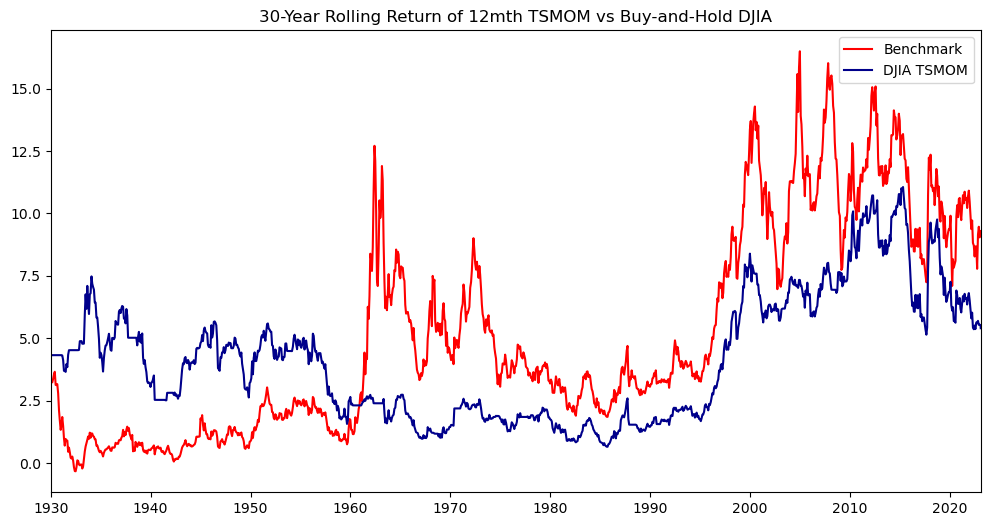

In [371]:
## 30yr rolling return
df['Strategy_Rolling_Ret'] = (1+df["12mth_TSMOM"]).rolling(window=360).apply(np.prod, raw=True) - 1    
df['Bmk_Rolling_Ret'] = df['Dow Jones'].pct_change(periods=360, axis=0).dropna(axis=0)
print(df.iloc[:,-2:].tail())

plt.figure(figsize=(12,6))
plt.plot(df['Bmk_Rolling_Ret'], color='red', label='Benchmark')
plt.plot(df['Strategy_Rolling_Ret'], color='darkblue', label='DJIA TSMOM')
plt.title('30-Year Rolling Return of 12mth TSMOM vs Buy-and-Hold DJIA')
plt.xlim(np.datetime64('1930-01-01'),np.datetime64('2023-02-08'))
plt.legend(loc=0)

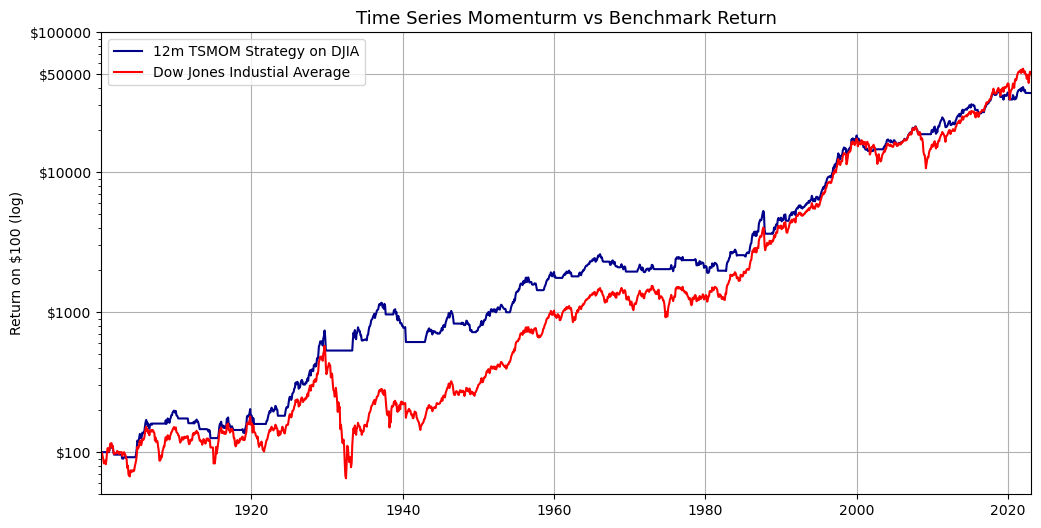

In [372]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(strategy, label="12m TSMOM Strategy on DJIA", color="darkblue")
ax.plot(bmk, label="Dow Jones Industial Average", color="red")
ax.set_title('Time Series Momenturm vs Benchmark Return',fontsize=13)
ax.set_ylabel('Return on $100 (log)')
ax.set_yscale('log')
ax.set_yticks(list(ax.get_yticks()) + [50000])
ax.set_ylim(50,100000)
ax.yaxis.set_major_formatter('${x:1.0f}')
ax.set_xlim(np.datetime64('1900-02-28'),np.datetime64('2023-02-08'))
ax.grid()
ax.legend(loc=0)

In [373]:
d = {'Strategy':strategy, 'Benchmark': bmk}
df2 = pd.DataFrame(data=d)
df2

,Strategy,Benchmark
Dates,,
1900-02-28,100.0,97.0
1900-03-31,100.0,99.0
1900-04-30,100.0,93.0
1900-05-31,100.0,89.0
1900-06-30,100.0,83.0
...,...,...
2022-10-31,36853.0,49498.0
2022-11-30,36853.0,52306.0
2022-12-30,36853.0,50124.0


Strategy:
Max Drawdown:-47.56%
Max Drawdown Duration: 208 days
Date of Max DrawDown: 1940-06-28 00:00:00

_____________

Benchmark:
Max Drawdown:-88.7%
Max Drawdown Duration: 302 days
Date of Max DrawDown: 1932-06-30 00:00:00

_____________



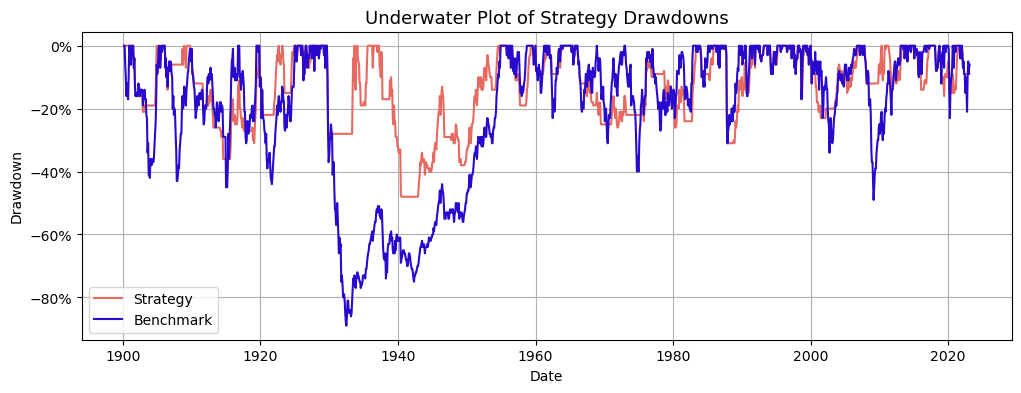

In [345]:
# DD and Return Stats
def calculate_MaxDD(dataframe, multi_frame=False, num_frames=1):
    """
    Calculates the drawdown statistics for an asset or strategy
    """
    if multi_frame==False:
        cumreturn = dataframe
        highwatermark = np.zeros(cumreturn.shape)
        drawdown = np.zeros(cumreturn.shape)
        drawdownduration = np.zeros(cumreturn.shape)

        for t in np.arange(1, cumreturn.shape[0]):
            highwatermark[t] = np.maximum(highwatermark[t - 1], cumreturn[t])
            drawdown[t] = (cumreturn[t] - highwatermark[t])/ (highwatermark[t])
            if drawdown[t] == 0:
                drawdownduration[t] = 0
            else:
                drawdownduration[t] = drawdownduration[t - 1] + 1

        maxDD, i = np.min(drawdown), np.argmin(drawdown)
        maxDDD = np.max(drawdownduration)
        DD_Date = cumreturn.index[i]
        return f"Max Drawdown:{round(maxDD*100,2)}%\nMax Drawdown Duration: {int(maxDDD)} days\nDate of Max DrawDown: {DD_Date}"
    
    else:
        for i in range(num_frames): 
            cumreturn = dataframe.iloc[:,i]
            highwatermark = np.zeros(cumreturn.shape)
            drawdown = np.zeros(cumreturn.shape)
            drawdownduration = np.zeros(cumreturn.shape)

            for t in np.arange(1, cumreturn.shape[0]):
                highwatermark[t] = np.maximum(highwatermark[t - 1], cumreturn[t])
                drawdown[t] = (cumreturn[t] - highwatermark[t])/ (highwatermark[t])
                if drawdown[t] == 0:
                    drawdownduration[t] = 0
                else:
                    drawdownduration[t] = drawdownduration[t - 1] + 1

            maxDD, i = np.min(drawdown), np.argmin(drawdown)
            maxDDD = np.max(drawdownduration)
            DD_Date = cumreturn.index[i]
            print(f"{cumreturn.name}:")
            print(f"Max Drawdown:{round(maxDD*100,2)}%\nMax Drawdown Duration: {int(maxDDD)} days\nDate of Max DrawDown: {DD_Date}\n")
            print("_____________\n")
    
def underwater_plot(dataframe, multi_frame=False, num_frames=1):
    """
    Plots the drawdown profile of an asset from the asset price dataframe
    """
    if multi_frame==False:
        cum_max = dataframe.cummax()
        drawdowns = (dataframe - cum_max) / cum_max
        drawdowns = round(drawdowns,2)
        
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(drawdowns.index, drawdowns, color="lightcoral")
        ax.fill_between(drawdowns.index, drawdowns, 0, where=drawdowns < 0, interpolate=True, color="whitesmoke")
        ax.set_title('Underwater Plot of Strategy Drawdowns',fontsize=13)
        ax.set_xlabel('Date')
        ax.set_ylabel('Drawdown')
        ax.grid()
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

    else:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.set_title('Underwater Plot of Strategy Drawdowns',fontsize=13)
        ax.set_xlabel('Date')
        ax.set_ylabel('Drawdown')
        for i in range(num_frames): 
            cum_max = dataframe.iloc[:,i].cummax()
            drawdowns = (dataframe.iloc[:,i] - cum_max) / cum_max
            drawdowns = round(drawdowns,2)
            ax.plot(drawdowns.index, drawdowns, color=list(np.random.uniform(0,1, size=3)), label=dataframe.columns[i])
        ax.legend(loc=0)
        ax.grid()
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))


underwater_plot(df2, multi_frame=True, num_frames=2)
calculate_MaxDD(df2, multi_frame=True, num_frames=2)

            Strategy_Rolling_12m_Ret  Bmk_Rolling_12m_Ret  \
Dates                                                       
2022-10-31                    -0.080               -0.086   
2022-11-30                    -0.044                0.003   
2022-12-30                    -0.093               -0.088   
2023-01-31                    -0.062               -0.030   
2023-02-08                    -0.029                0.005   

            Strategy_Rolling_vol  Bmk_Rolling_vol  
Dates                                              
2022-10-31                 0.095            0.227  
2022-11-30                 0.090            0.232  
2022-12-30                 0.067            0.228  
2023-01-31                 0.062            0.229  
2023-02-08                 0.054            0.225  


<function matplotlib.pyplot.show(close=None, block=None)>

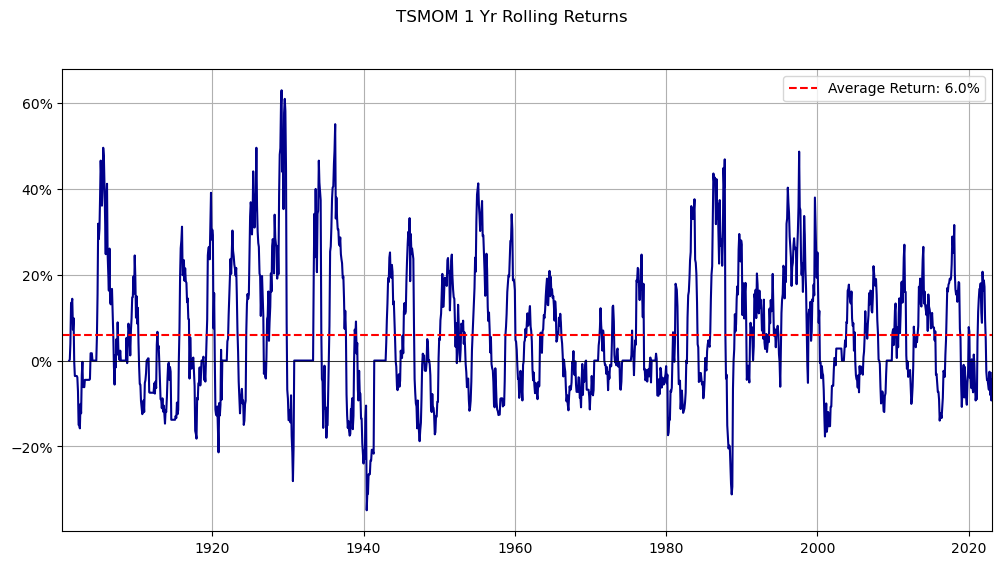

In [374]:
# Calculating the Sharpe
# 1yr rolling returns and vol
df['Strategy_Rolling_12m_Ret'] = round(((1+df["12mth_TSMOM"]).rolling(12).apply(np.prod, raw=True) - 1),3)
df['Bmk_Rolling_12m_Ret'] = round(df['Dow Jones'].pct_change(periods=12, axis=0).dropna(axis=0),3)

df['Strategy_Rolling_vol'] = round(df['12mth_TSMOM'].rolling(12).apply(np.std, raw=True)*(12**0.5),3) #scaling to yearly vol
df['Bmk_Rolling_vol'] = round(df['DJIA_Return'].rolling(12).std()*(12**0.5), 3) #pct_change(periods=12, axis=0)
print(df.iloc[:,-4:].tail())

fig = plt.figure(figsize=(12, 6))
fig.suptitle('TSMOM 1 Yr Rolling Returns')

ax = fig.add_subplot(111)
ax.plot(df['Strategy_Rolling_12m_Ret']*100, color='darkblue')

ax.axhline(y=(df['Strategy_Rolling_12m_Ret'].mean()*100), color='red', ls='--', lw=1.5, label="Average Return: " + str(round(df['Strategy_Rolling_12m_Ret'].mean()*100,0)) + "%")
ax.axhline(y=0, color='black', lw=0.5)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlim(np.datetime64('1900-02-28'),np.datetime64('2023-02-08'))
plt.legend(loc='best')
plt.grid()
plt.show

In [375]:
# Adding a risk-free rate
rfr = pd.read_csv('Bonds.csv')
rfr.set_index('Dates', inplace=True)
rfr.drop(columns=['US_10yr', 'US_2yr', 'US_20yr', 'VIX Index', 'Bond_VIX', 'FX_VIX', 'US_3mth'], inplace=True)
rfr.fillna(value=6, inplace=True) #backfilling risk-free rate assuming a constant 6%
rfr.index = pd.to_datetime(rfr.index, format = '%d/%m/%Y') 
rfr = rfr.loc[rfr.groupby(rfr.index.to_period('M')).apply(lambda x: x.index.max())]
rfr = rfr/100
print(rfr)

df = df.merge(rfr, on='Dates')
df.drop(columns=['Entry', 'Strategy_Rolling_Ret', 'Bmk_Rolling_Ret','12mth_TSMOM', 'DJIA_Return', 'Dow Jones'], inplace=True)
df.dropna(inplace=True)
df.head()

             US_1mth
Dates               
1900-01-31  0.060000
1900-02-28  0.060000
1900-03-31  0.060000
1900-04-30  0.060000
1900-05-31  0.060000
...              ...
2022-12-30  0.043916
2023-01-31  0.045743
2023-02-28  0.046694
2023-03-31  0.048577
2023-04-26  0.050161

[1480 rows x 1 columns]


,Strategy_Rolling_12m_Ret,Bmk_Rolling_12m_Ret,Strategy_Rolling_vol,Bmk_Rolling_vol,US_1mth
Dates,,,,,
1901-02-28,0.002,0.048,0.002,0.228,0.06
1901-03-29,0.039,0.062,0.035,0.229,0.06
1901-04-30,0.134,0.236,0.091,0.230,0.06
1901-05-31,0.134,0.282,0.091,0.223,0.06
1901-06-28,0.144,0.395,0.091,0.199,0.06


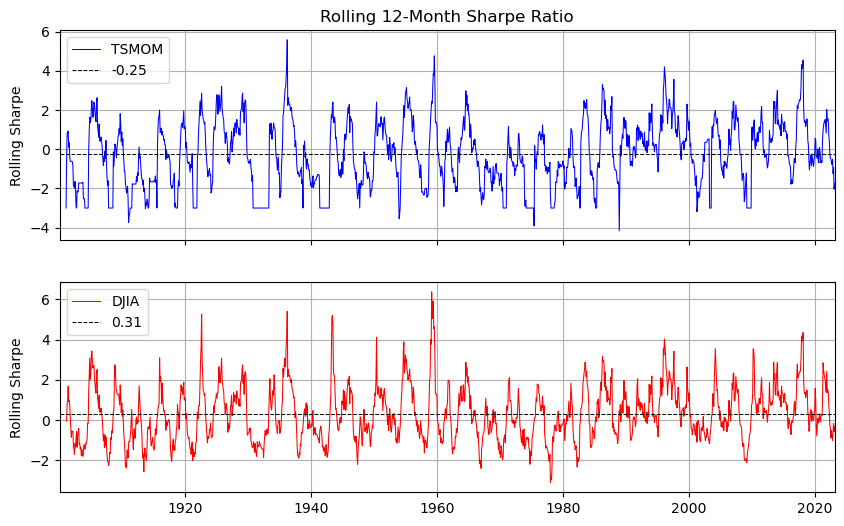

In [376]:
# Plot rolling 12 month sharpe ratio
strat_return = df['Strategy_Rolling_12m_Ret']
strat_vol = df['Strategy_Rolling_vol'] 
strategy_sharpe = (strat_return - df['US_1mth']) / strat_vol

for i in range(len(strategy_sharpe)):
    if strategy_sharpe[i] < -5:
        strategy_sharpe[i] = -3

# plotting the sharpe ratio
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True) 
ax1.title.set_text('Rolling 12-Month Sharpe Ratio')
ax1.plot(strategy_sharpe, label='TSMOM', color='blue', lw=0.75)
ax1.axhline(y=strategy_sharpe.mean(), lw=0.75, ls='--', color='black', label=round(strategy_sharpe.mean(), 2))
ax1.set_ylabel('Rolling Sharpe')
ax1.set_xlim(np.datetime64('1900-02-28'),np.datetime64('2023-02-08'))
ax1.grid()
ax1.legend(loc='best')

# calculating DJIA sharpe ratio
bmk_return = df['Bmk_Rolling_12m_Ret']
bmk_vol = df['Bmk_Rolling_vol'] 
bmk_sharpe = (bmk_return - df['US_1mth']) / bmk_vol

# plotting the sharpe ratio
ax2.plot(bmk_sharpe, label='DJIA', color='red', lw=0.75)
ax2.axhline(y=bmk_sharpe.mean(), lw=0.75, ls='--', color='black', label=round(bmk_sharpe.mean(), 2))
ax2.set_ylabel('Rolling Sharpe')
ax2.set_xlim(np.datetime64('1900-02-28'),np.datetime64('2023-02-08'))
ax2.grid()
ax2.legend(loc='best')